# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image

from scipy.interpolate import interp1d

import scikitplot as skplt

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn.preprocessing import OrdinalEncoder as oe

from sklearn    import linear_model as lm
from sklearn    import ensemble as en
from sklearn    import neighbors

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## 0.1 Helper Functions

In [2]:
def show_percentage(ax, df):
    for p in ax.patches:
        height = p.get_height()
        # Adicionar rótulo de porcentagem somente se a altura da barra for maior que 0
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., 
                    height + 0.05, 
                    '{:.2f}%'.format(height * 100 / len(df)), 
                    ha="center")


def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None

    sns.set()

def precision_at_k(data, k = 1000):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index +1

    data['precision_at_k'] = data['Exited'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, k = 1000):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index +1

    data['recall_at_k'] = data['Exited'].cumsum() / data['Exited'].sum()

    return data.loc[k, 'recall_at_k']



def precision_recall_at_k(model_name, x_val, y_val, y_prob, top_k = 1000):
    df8 = x_val.copy()
    df8['Exited'] = y_val.copy()

    df8['score'] = y_prob[:,1].tolist()

    # Sort by propensity score
    df8 = df8.sort_values(by='score', ascending=False).reset_index(drop=True)

    # Precision at k
    precision_at_x = round(precision_at_k(data = df8, k = top_k),4)
    recall_at_x = round(recall_at_k(data = df8, k = top_k),4)


    return pd.DataFrame({'Model Name': model_name,
                         'Precision at k': precision_at_x,
                         'Recall at k': recall_at_x}, index=[0])




def cross_validation (model_name, model, x_train, x_val,y_train,y_val, n_splits, n_repeats, top_k = 1000, verbose=False):
    
    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1
    
    # the seed usage provides repeatability 
    np.random.seed(42)
    
    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train,x_val])
    y = pd.concat([y_train,y_val])
    
    
    # definition of the cross-validation strategy
    cv = ms.RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )
    
    precision_at_x = []
    recall_at_x = []
    
    for train_index, val_index in cv.split(x, y):      
        x_train_n , x_val_n = x.iloc[train_index], x.iloc[val_index]
        y_train_n, y_val_n = y.iloc[train_index], y.iloc[val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_train_n.shape[0]}\nvalidation_lenght:{x_val_n.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_train_n, y_train_n)
        yhat_proba = model.predict_proba(x_val_n)

        df_aux = x_val_n.copy()
        df_aux['Exited'] = y_val_n.values
        df_aux['score'] = yhat_proba[:,1].tolist()

        # Sort by propensity score
        df_aux = df_aux.sort_values(by='score', ascending=False).reset_index(drop=True)       
    

        # save the metrics value to the list
        precision_at_x.append(precision_at_k(data = df_aux, k = top_k))
        recall_at_x.append(recall_at_k(data = df_aux, k = top_k))
        

    return pd.DataFrame({ 'Model Name': model_name,
                          'Precision': round(np.mean(precision_at_x), 3).astype(str) + '+/-' + round(np.std(precision_at_x),2).astype(str),
                          'Recall': round(np.mean(recall_at_x), 3).astype(str) + '+/-' + round(np.std(recall_at_x),2).astype(str)}, 
                          index=[0])



def evaluate_classification_model(model_name, y_test, y_pred):
    # Calcular as métricas
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Criar um DataFrame com as métricas
    metrics = {
        'Model':[model_name],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    }
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

def plot_confusion_matrix(cm, class_names):
    # Criar um DataFrame para a matriz de confusão
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.title('Matriz de Confusão')
    plt.show()

In [3]:
jupyter_settings()

## 0.2 Loading Dataset

In [4]:
data_raw = pd.read_csv('./datasets/churn.csv')

In [5]:
X = data_raw.drop(['RowNumber', 'CustomerId', 'Exited', 'Surname'], axis=1)
y = data_raw['Exited']

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## 1.0 DATA DESCRIPTION

In [6]:
data_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 1.1. Rename Columns

There's no need to change anything about the columns, they're all correct.

In [7]:
data_raw.columns.tolist()

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

### 1.2. Data Dimensions

In [8]:
print(f'Number of rows: {data_raw.shape[0]}')
print(f'Number of cols: {data_raw.shape[1]}')

Number of rows: 10000
Number of cols: 14


### 1.3. Data Types

In [9]:
data_raw.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

### 1.4. Check NA

In [10]:
data_raw.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [11]:
data_raw.duplicated().sum()

0

### 1.5. Fill NA

We have no empty data, no need to fill anything

### 1.6. Change Types

In [12]:
data_raw['HasCrCard'] = data_raw['HasCrCard'].astype('int64')

x_train['HasCrCard'] = x_train['HasCrCard'].astype('int64')
x_test['HasCrCard'] = x_test['HasCrCard'].astype('int64')

### 1.7. Columns Description

### 1.8. Data Statistical

In [13]:
num_attributes = data_raw.select_dtypes(include=['int64', 'float64'])
cat_attributes = data_raw.select_dtypes(include=['object'])

#### 1.8.1 Numerical Attributes

In [14]:
min_ =  pd.DataFrame(num_attributes.apply(np.min)).T
max_ =  pd.DataFrame(num_attributes.apply(np.max)).T

mean_ =  pd.DataFrame(num_attributes.apply(np.mean)).T
median_ =  pd.DataFrame(num_attributes.apply(np.median)).T

std_ =  pd.DataFrame(num_attributes.apply(np.std)).T
range_ =  pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_ =  pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ =  pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


data_describe =pd.concat([min_, max_, mean_, median_, std_, range_, skew_, kurtosis_]).T.reset_index()
data_describe.columns = ['attributes', 'min', 'max', 'mean', 'median', 'std', 'range', 'skew', 'kurtosis']

data_describe.round(2)

,attributes,min,max,mean,median,std,range,skew,kurtosis
0,RowNumber,1.00,10000.00,5000.50,5000.50,2886.75,9999.00,0.00,-1.20
1,CustomerId,15565701.00,15815690.00,15690940.57,15690738.00,71932.59,249989.00,0.00,-1.20
2,CreditScore,350.00,850.00,650.53,652.00,96.65,500.00,-0.07,-0.43
3,Age,18.00,92.00,38.92,37.00,10.49,74.00,1.01,1.40
4,Tenure,0.00,10.00,5.01,5.00,2.89,10.00,0.01,-1.17
5,Balance,0.00,250898.09,76485.89,97198.54,62394.29,250898.09,-0.14,-1.49
6,NumOfProducts,1.00,4.00,1.53,1.00,0.58,3.00,0.75,0.58
7,HasCrCard,0.00,1.00,0.71,1.00,0.46,1.00,-0.90,-1.19
8,IsActiveMember,0.00,1.00,0.52,1.00,0.50,1.00,-0.06,-2.00
9,EstimatedSalary,11.58,199992.48,100090.24,100193.92,57507.62,199980.90,0.00,-1.18


#### 1.8.2. Categorical Attributes

In [15]:
# number of unique categories in each object columns
cat_attributes.apply(lambda x: x.unique().shape[0])

Surname      2932
Geography       3
Gender          2
dtype: int64

In [16]:
for i in cat_attributes.columns:
    print(f'{i}: {cat_attributes[i].unique()}')

Surname: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Geography: ['France' 'Spain' 'Germany']
Gender: ['Female' 'Male']


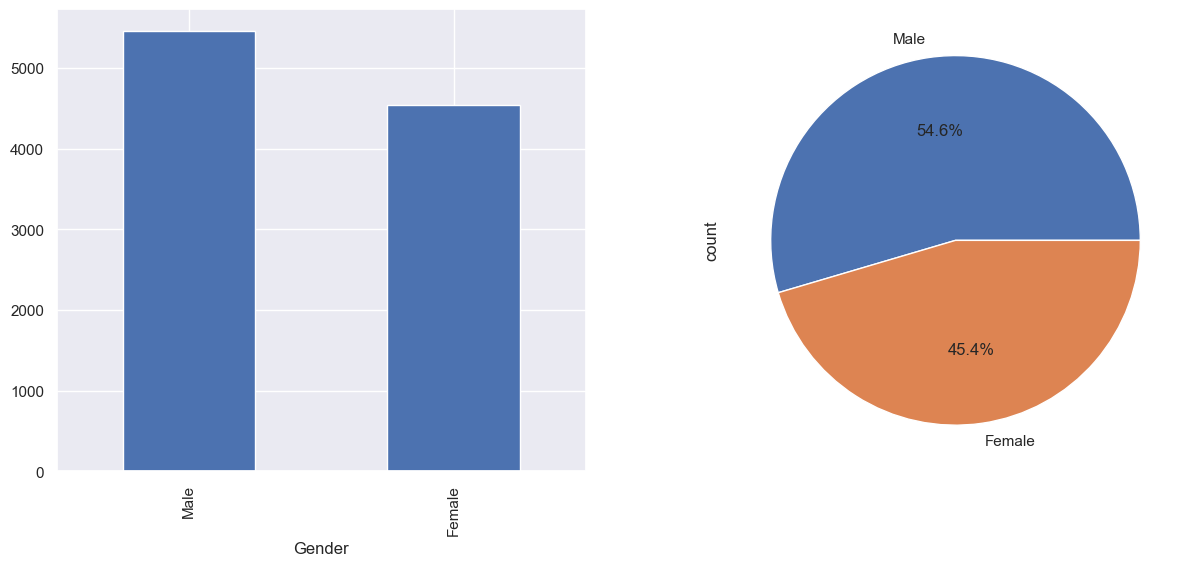

In [17]:
# Gender
# I have 9% more male customers than female

plt.subplot(1, 2, 1)
cat_attributes['Gender'].value_counts().plot(kind='bar', figsize=(15, 6))
plt.subplot(1, 2, 2)
cat_attributes['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(15, 6));


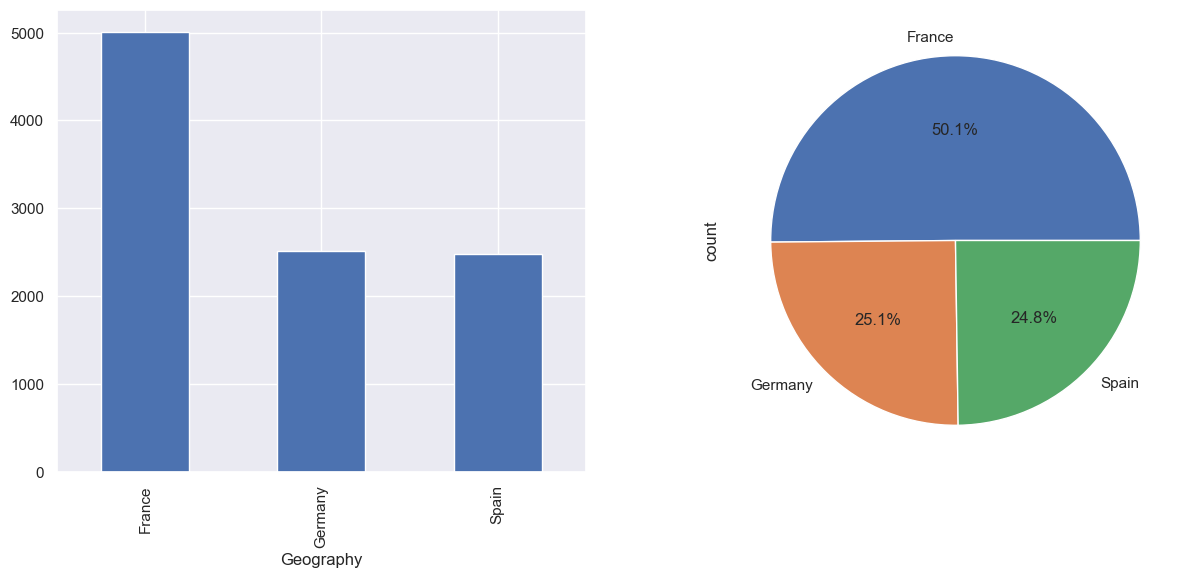

In [18]:

# Geography
# I have 50% of customers from France
plt.subplot(1, 2, 1)
cat_attributes['Geography'].value_counts().plot(kind='bar', figsize=(15, 6))
plt.subplot(1, 2, 2)
cat_attributes['Geography'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(15, 6));

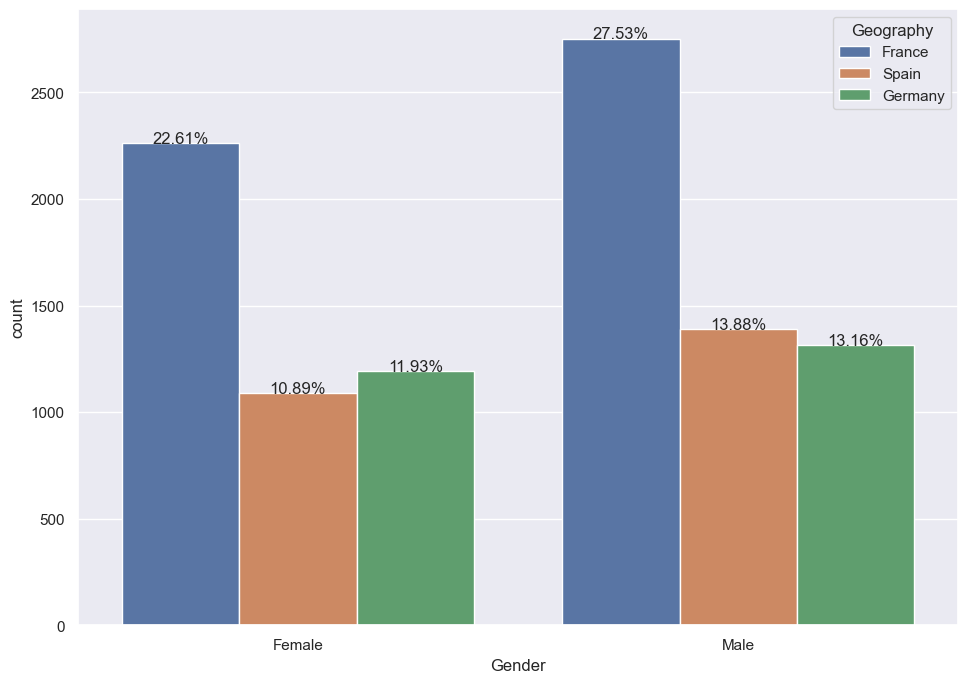

In [19]:
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', hue='Geography', data=cat_attributes)
show_percentage(df=cat_attributes, ax=plt.gca())


## 2.0. FEATURE ENGINEERING

### 2.1.1 Training Dataset

In [20]:
x_train['Gender'] = x_train['Gender'].map({'Male': 0, 'Female': 1})

### 2.1.1 Test Dataset

In [21]:
x_test['Gender'] = x_test['Gender'].map({'Male': 0, 'Female': 1})

## 3.0. DATA FILTERING

In [22]:
df3 = pd.concat([x_train, y_train], axis = 1)

## 4.0. EDA

In [23]:
df4 = df3.copy()

### 4.1 Análise Univáriada

Como podemos constatar através do gráfico, temos uma variável resposta desbalanceda.

#### 4.1.1 Target

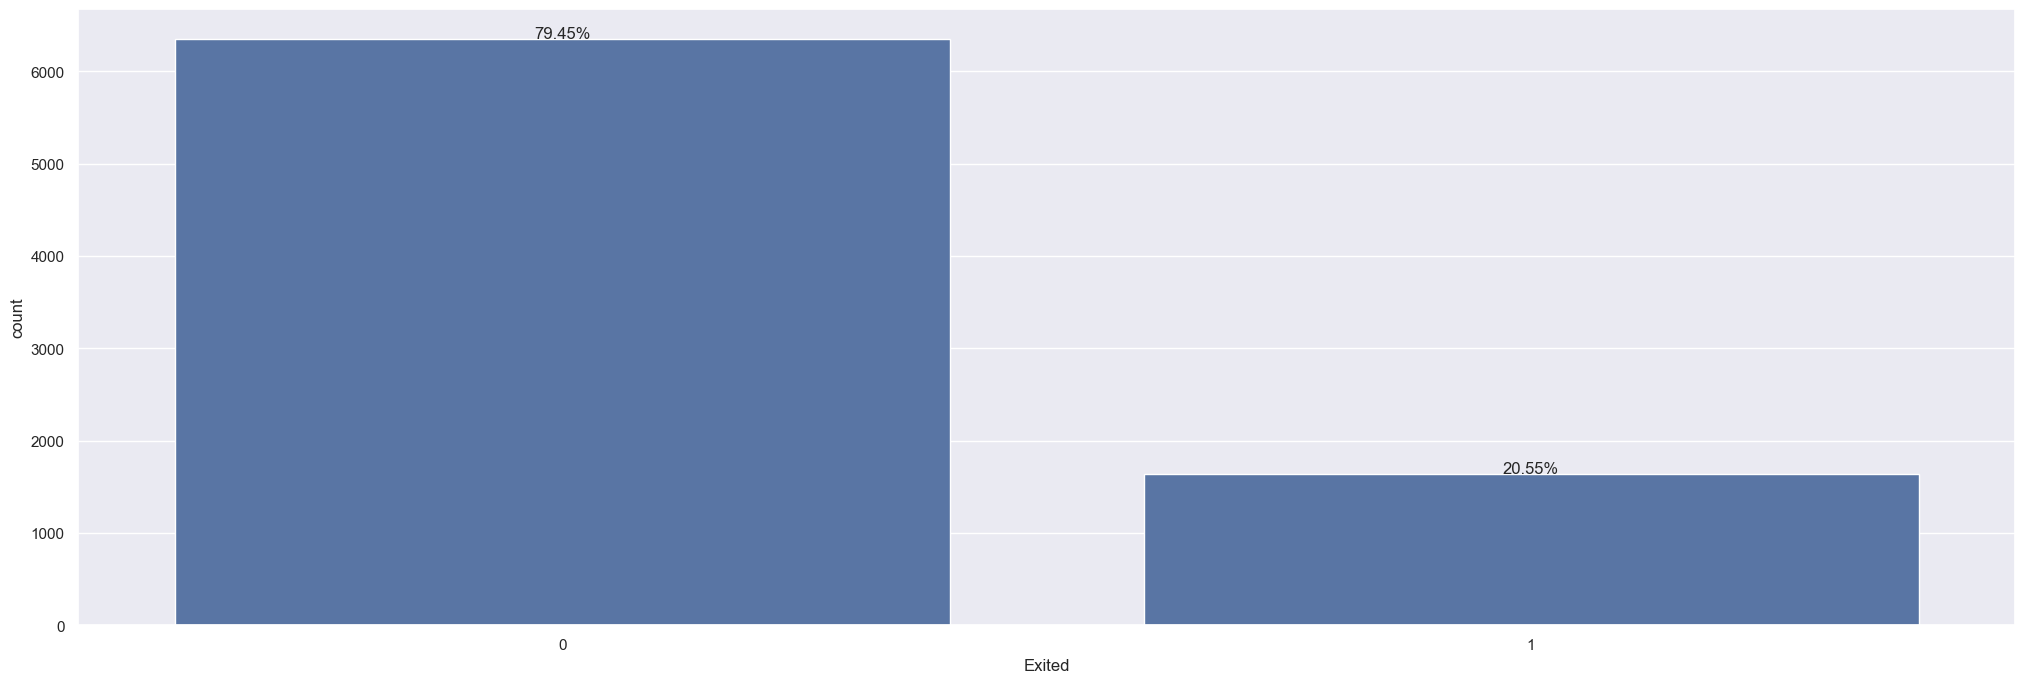

In [24]:
ax = sns.countplot(data=df4, x='Exited')
show_percentage(ax, df4)


#### 4.1.2 Gender

Womans exited more than mans


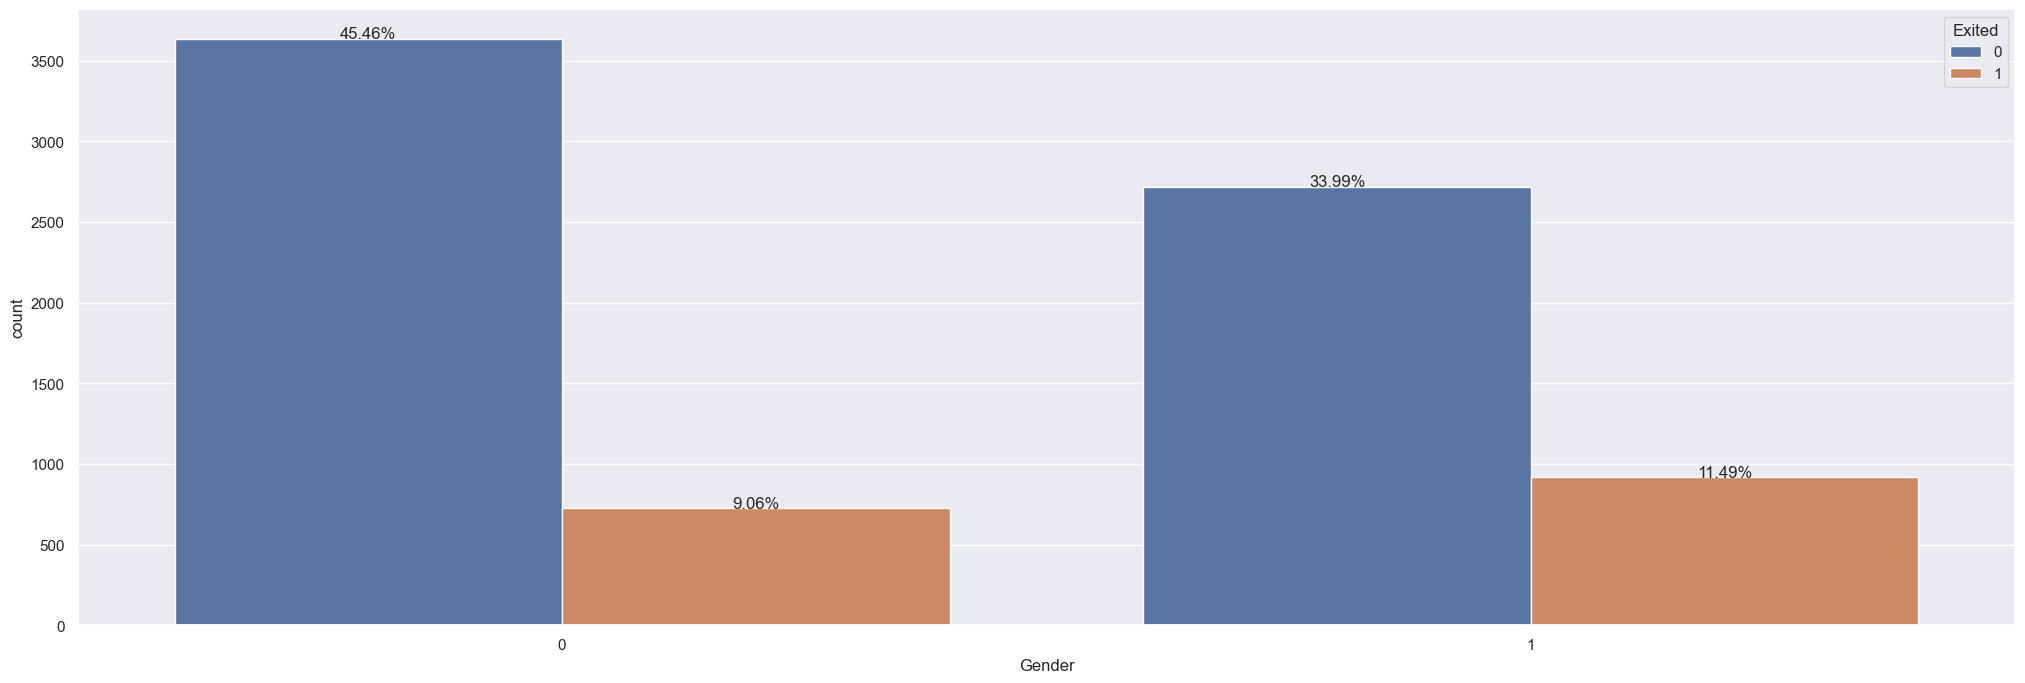

In [25]:
# Gender 
ax1 = sns.countplot(x = 'Gender', hue = 'Exited', data = df4)
show_percentage(ax1, df4)

#### 4.1.2 Geography

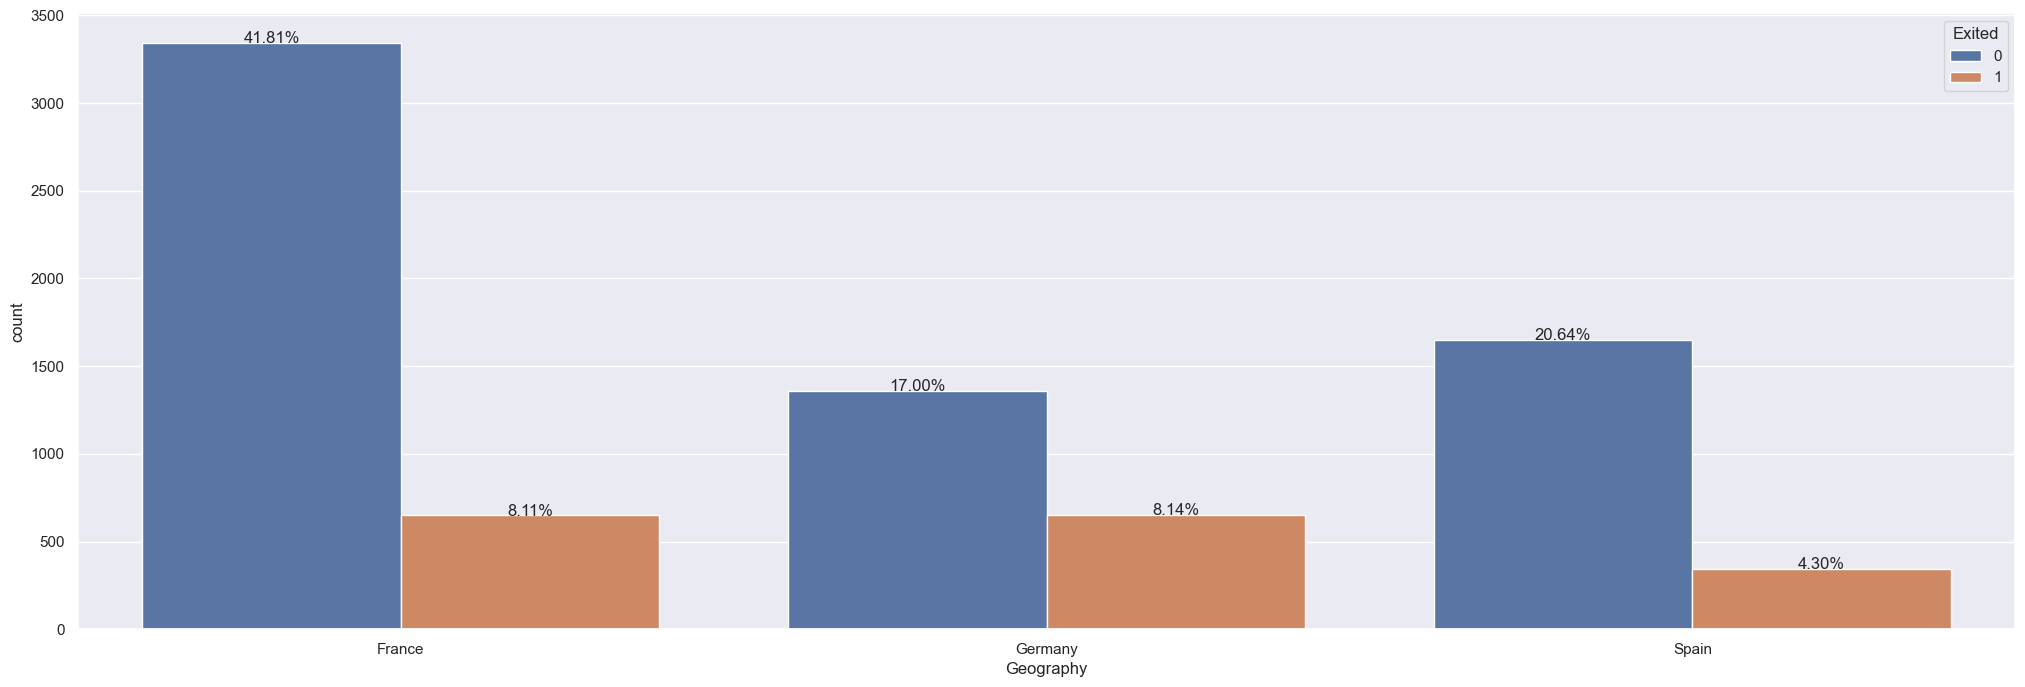

In [26]:
ax2 = sns.countplot(x = 'Geography', hue = 'Exited', data = df4)
show_percentage(ax2, df4)

#### 4.1.3 Age

Distruibuição normal entre as varaiveis Age e Exited.
Observado muitos outliers na variavel Age quando se trata de clientes que não cancelaram

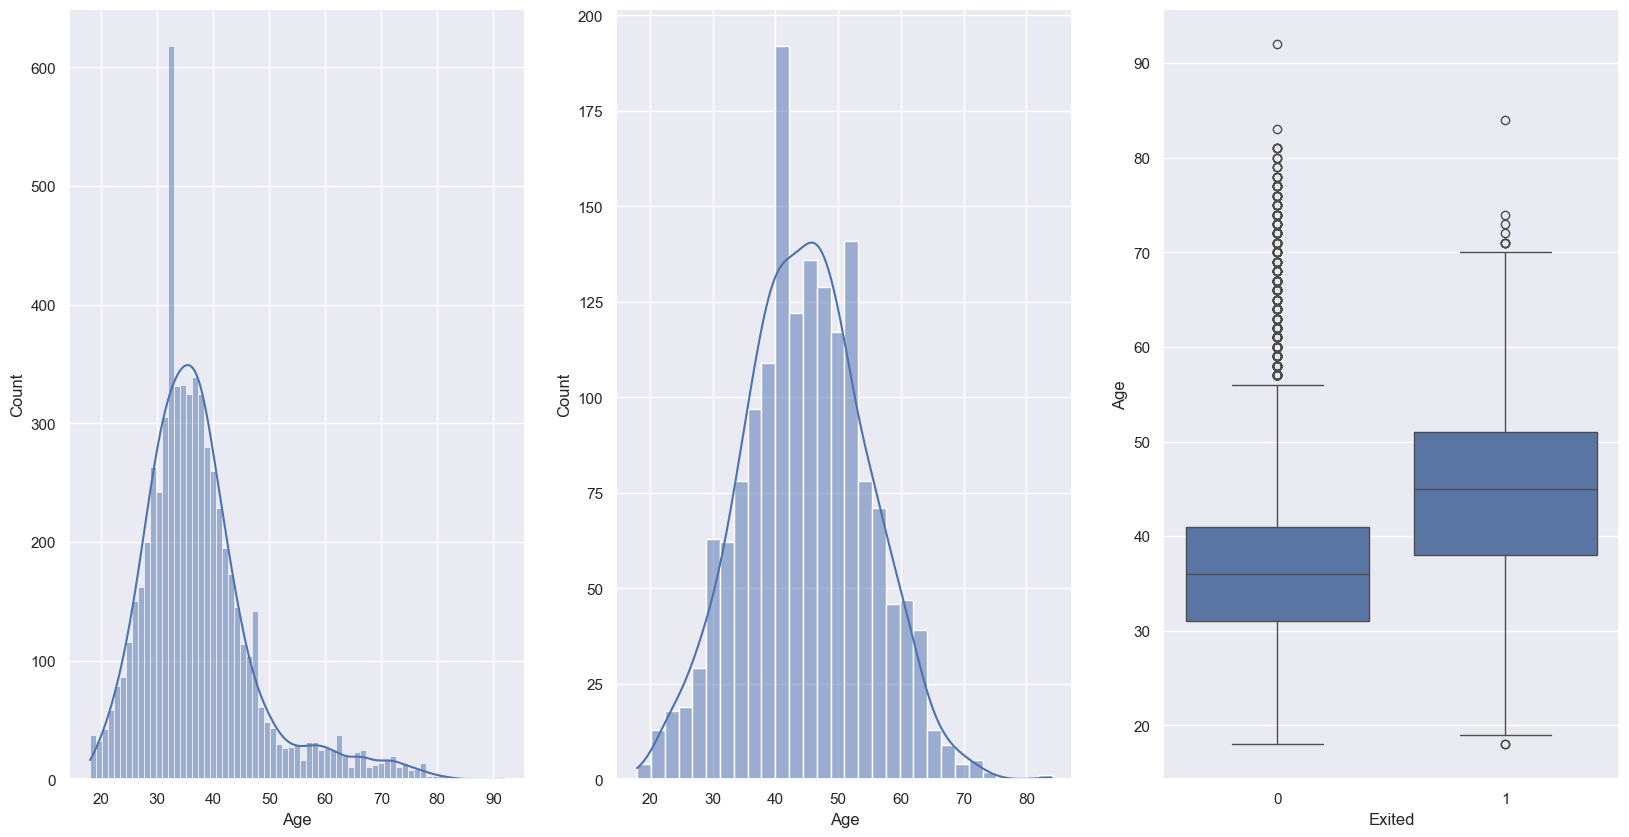

In [27]:
# Age
plt.figure(figsize = (20, 10))
aux_0 = df4.loc[df4['Exited'] == 0, 'Age']
aux_1 = df4.loc[df4['Exited'] == 1, 'Age']

plt.subplot(1, 3, 1)
sns.histplot(aux_0, kde = True)

plt.subplot(1, 3, 2)
sns.histplot(aux_1, kde = True);

plt.subplot(1, 3, 3)
sns.boxplot(x = df4['Exited'], y = df4['Age']);

#### 4.1.4 Credit Score

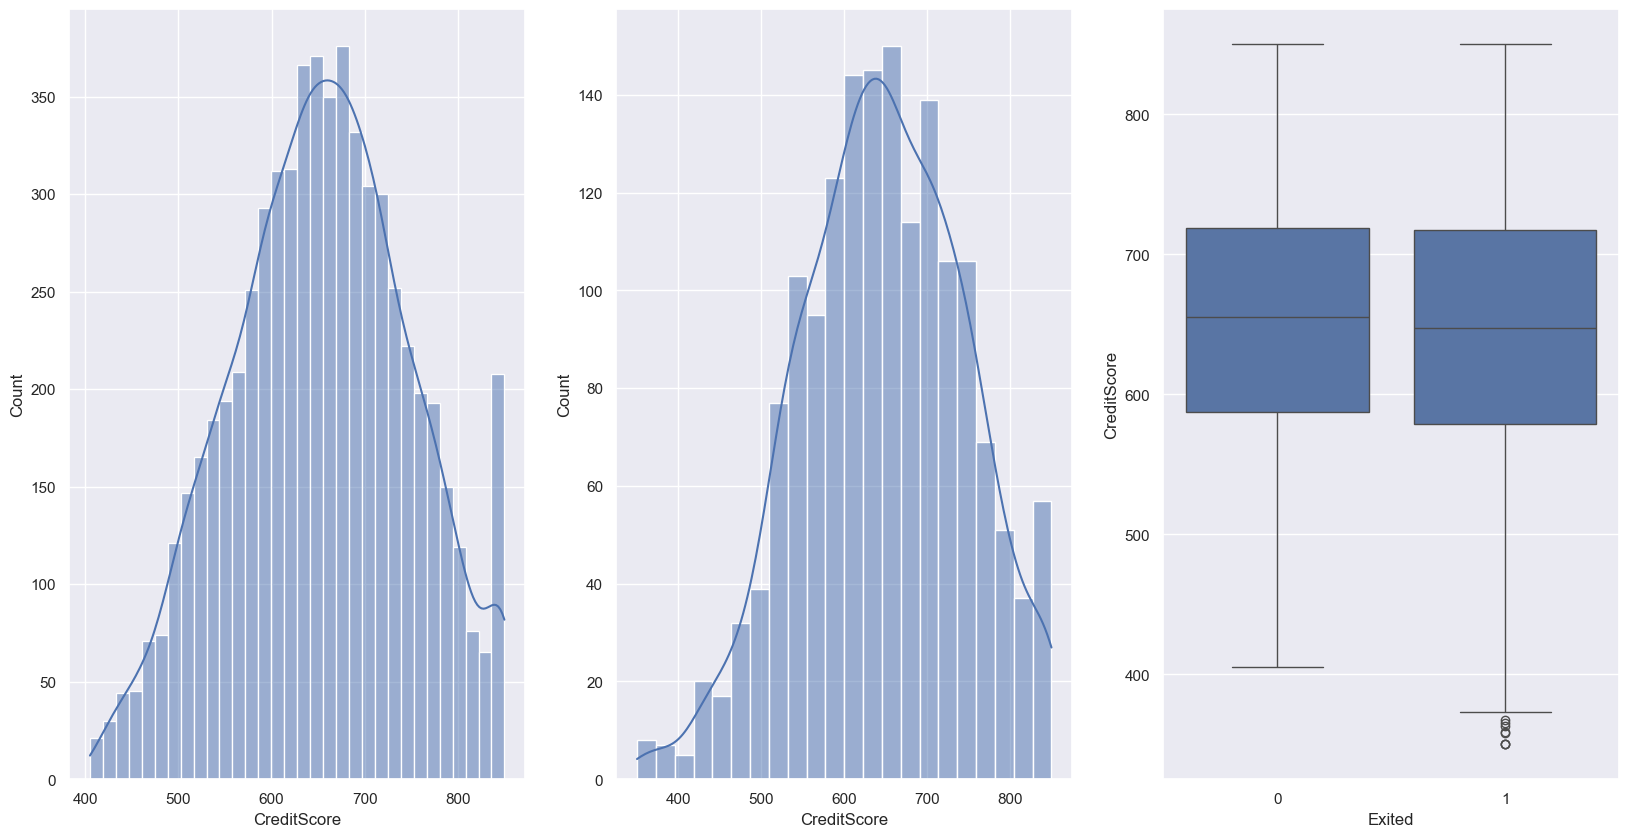

In [28]:
# Age
plt.figure(figsize = (20, 10))
aux_0 = df4.loc[df4['Exited'] == 0, 'CreditScore']
aux_1 = df4.loc[df4['Exited'] == 1, 'CreditScore']

plt.subplot(1, 3, 1)
sns.histplot(aux_0, kde = True)

plt.subplot(1, 3, 2)
sns.histplot(aux_1, kde = True);

plt.subplot(1, 3, 3)
sns.boxplot(x = df4['Exited'], y = df4['CreditScore']);

#### 4.1.5 Tenure

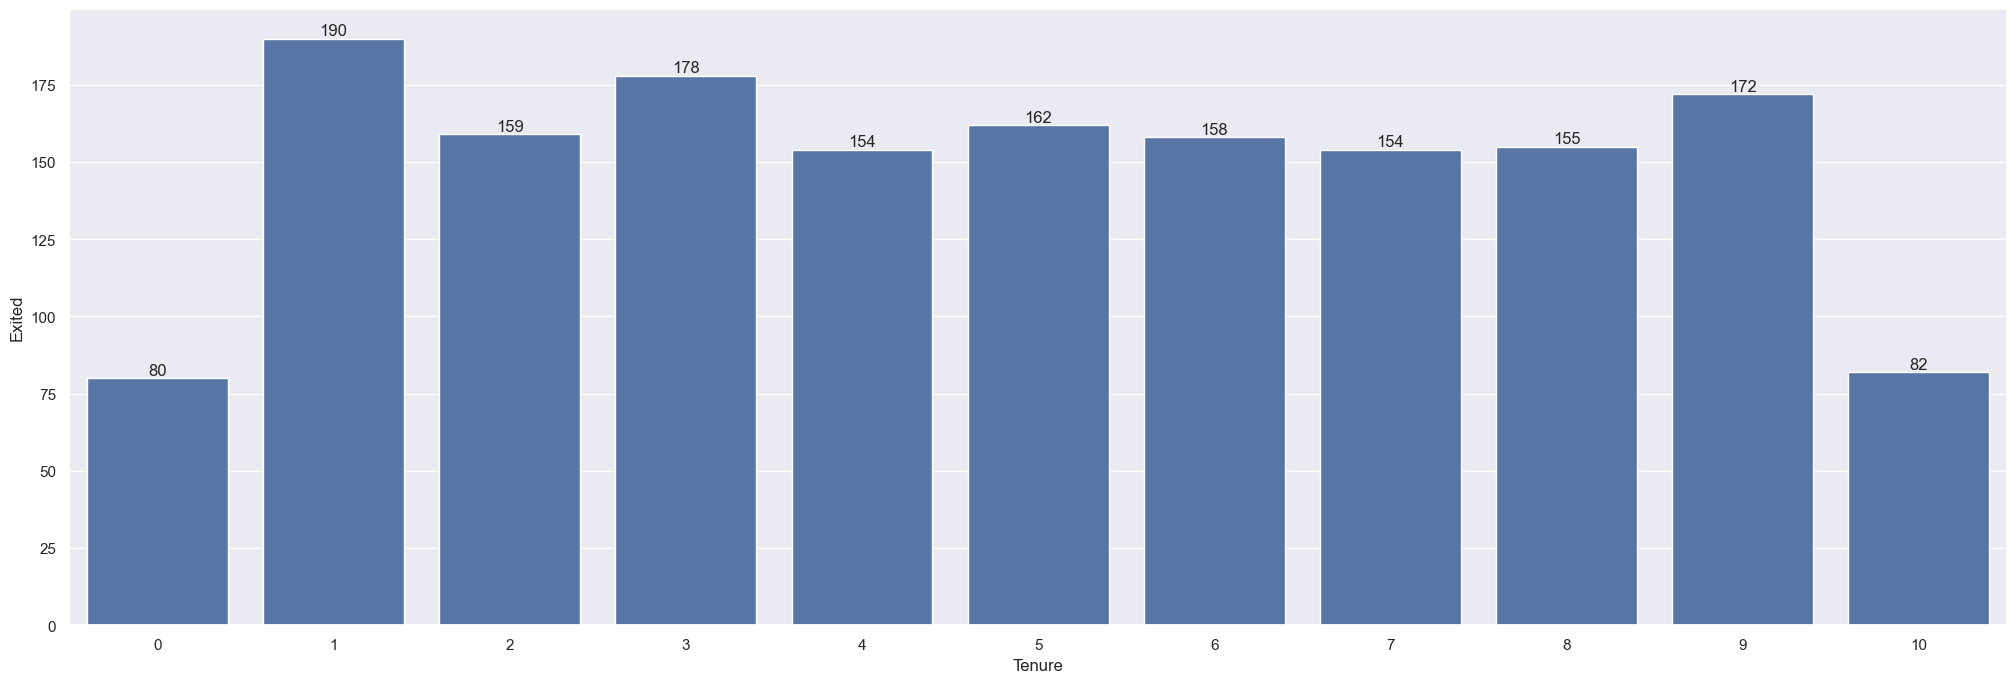

In [29]:
aux = df4[['Tenure', 'Exited']].groupby('Tenure').sum().reset_index()

ax = sns.barplot(x = 'Tenure', y = 'Exited', data = aux)
ax.bar_label(ax.containers[0]);


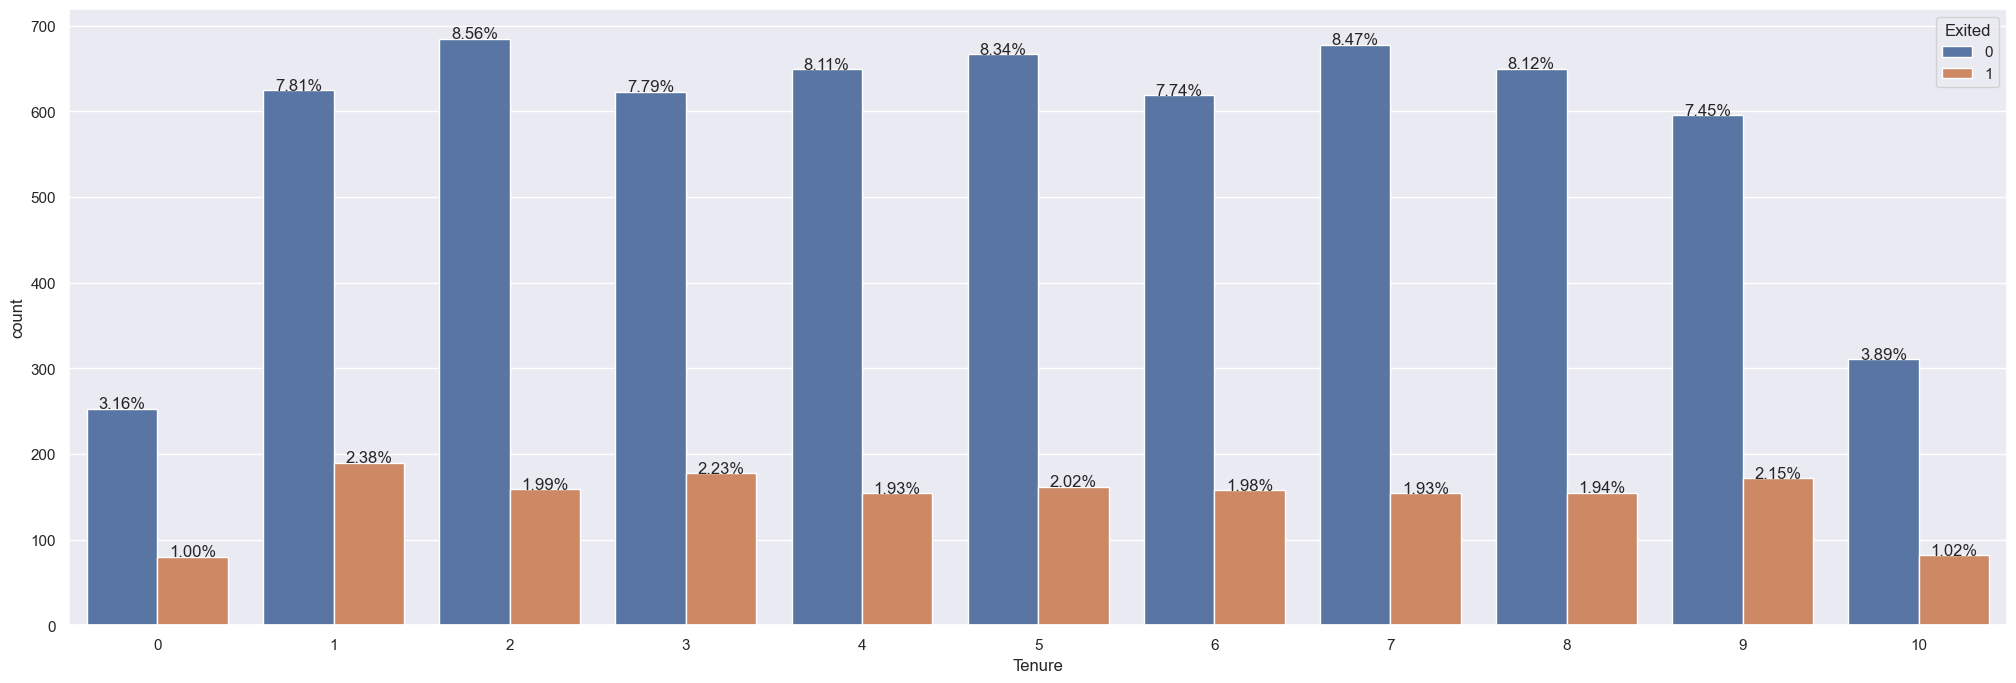

In [30]:
ax1 = sns.countplot(x='Tenure', hue='Exited', data=df4)
show_percentage(ax1, df4)

#### 4.1.6 Balance

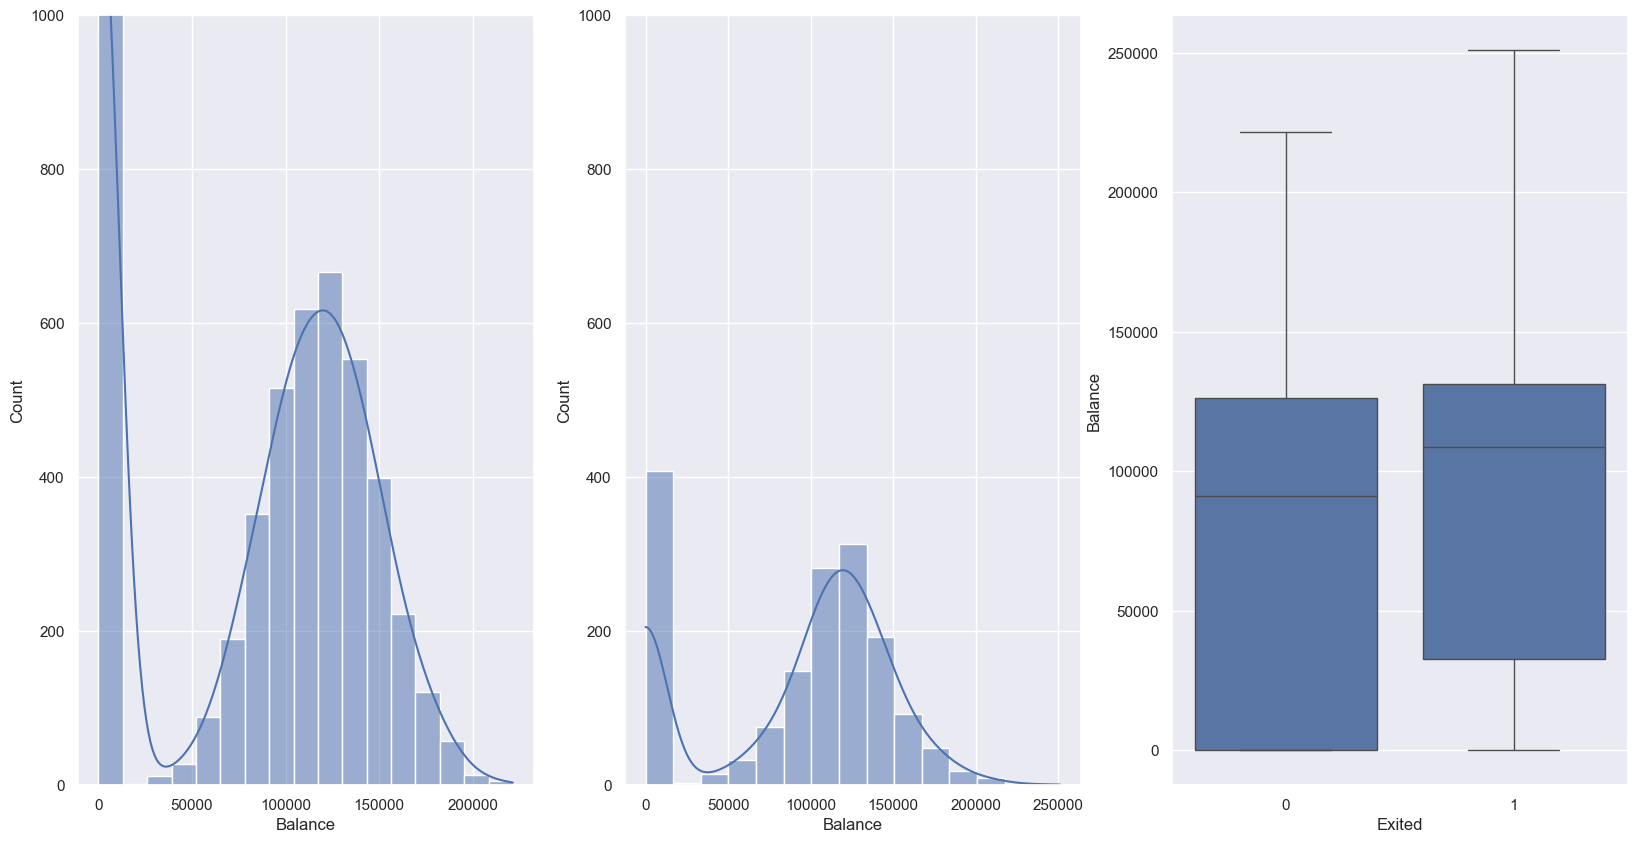

In [31]:
# Age
plt.figure(figsize = (20, 10))
aux_0 = df4.loc[df4['Exited'] == 0, 'Balance']
aux_1 = df4.loc[df4['Exited'] == 1, 'Balance']

max_y = max(aux_0.max(), aux_1.max())

plt.subplot(1, 3, 1)
sns.histplot(aux_0, kde = True)
plt.ylim(0, 1000)

plt.subplot(1, 3, 2)
sns.histplot(aux_1, kde = True)
plt.ylim(0, 1000)

plt.subplot(1, 3, 3)
sns.boxplot(x = df4['Exited'], y = df4['Balance']);

#### 4.1.7 NumOfProducts

More than 90% of the customers are between 1 or 2 NumOfProducts

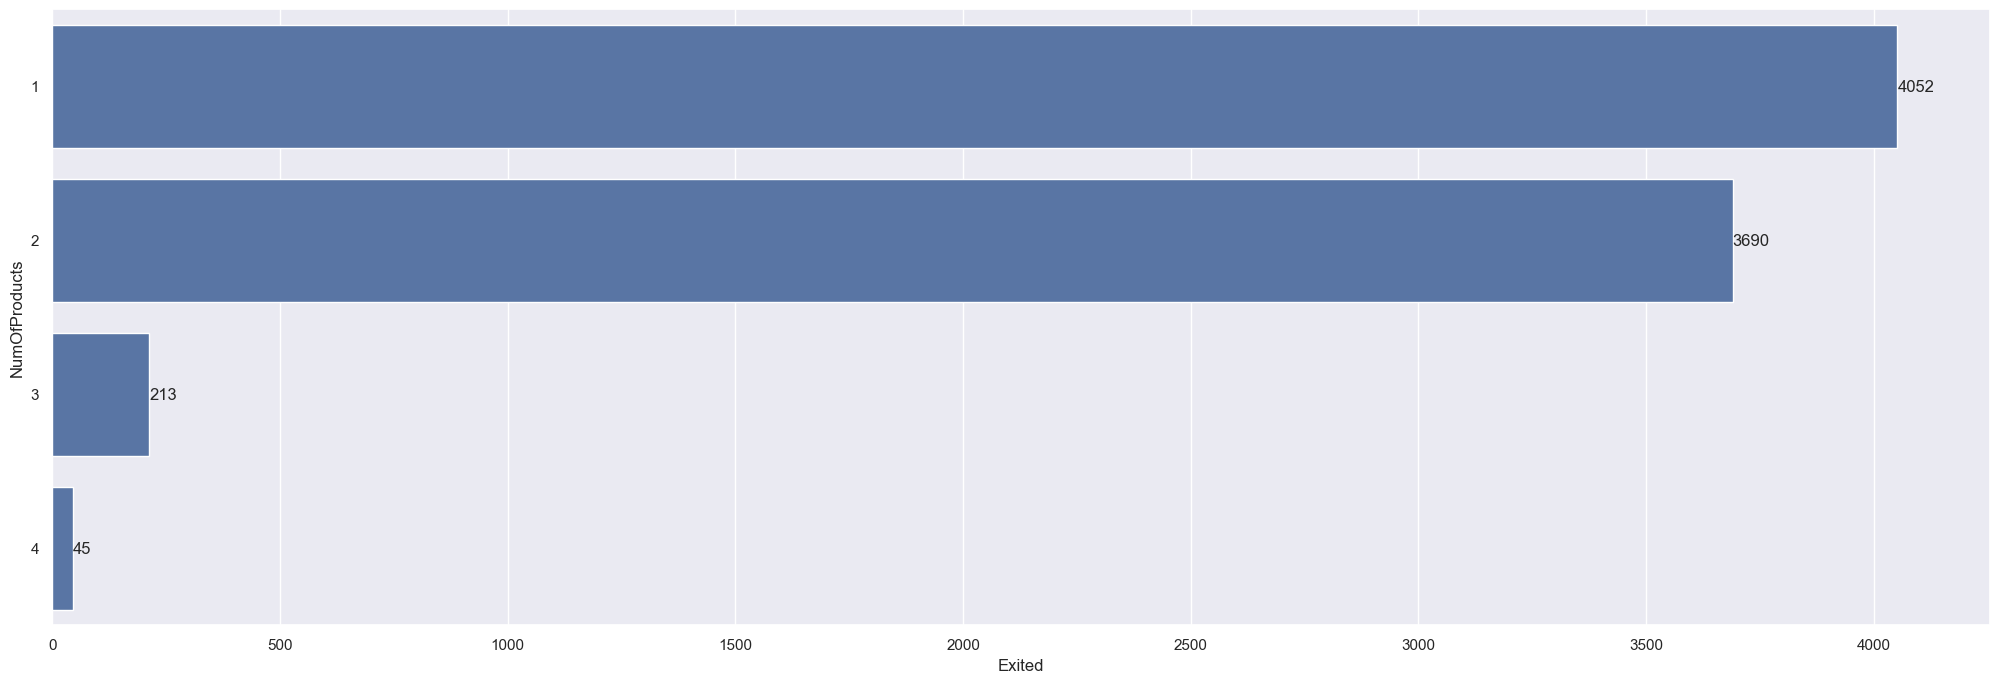

In [32]:
aux = df4[['NumOfProducts', 'Exited']].groupby('NumOfProducts').count().reset_index()


ax = sns.barplot(x='Exited', y= 'NumOfProducts', data = aux, orient = 'h')
ax.bar_label(ax.containers[0]);

#### 4.1.8 HasCrCard

Clients with no credit card exited less than others

In [33]:
dl = pd.crosstab(df4['HasCrCard'], df4['Exited']).apply(lambda x: x / x.sum(), axis = 1)
dl

Exited,0,1
HasCrCard,,
0,0.790472,0.209528
1,0.796198,0.203802


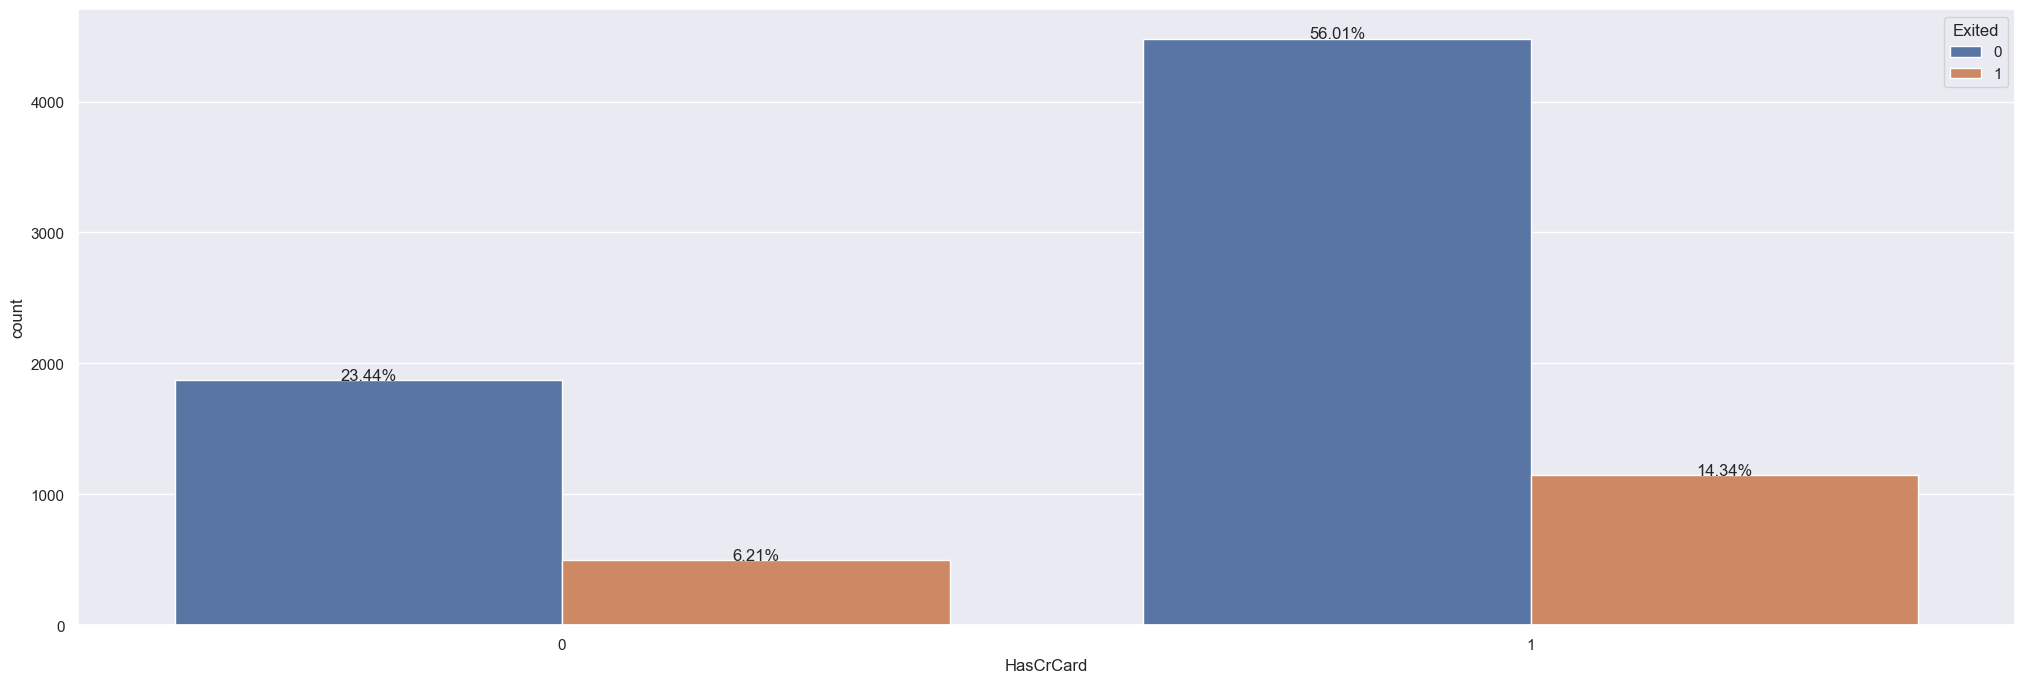

In [34]:
ax1 = sns.countplot(x = 'HasCrCard', hue = 'Exited', data = df4)
show_percentage(ax1, df4)

#### 4.1.9 IsActiveMember

Active members exited less than others

In [35]:
dl = pd.crosstab(df4['IsActiveMember'], df4['Exited']).apply(lambda x: x / x.sum(), axis = 1)
dl


Exited,0,1
IsActiveMember,,
0,0.729605,0.270395
1,0.856168,0.143832


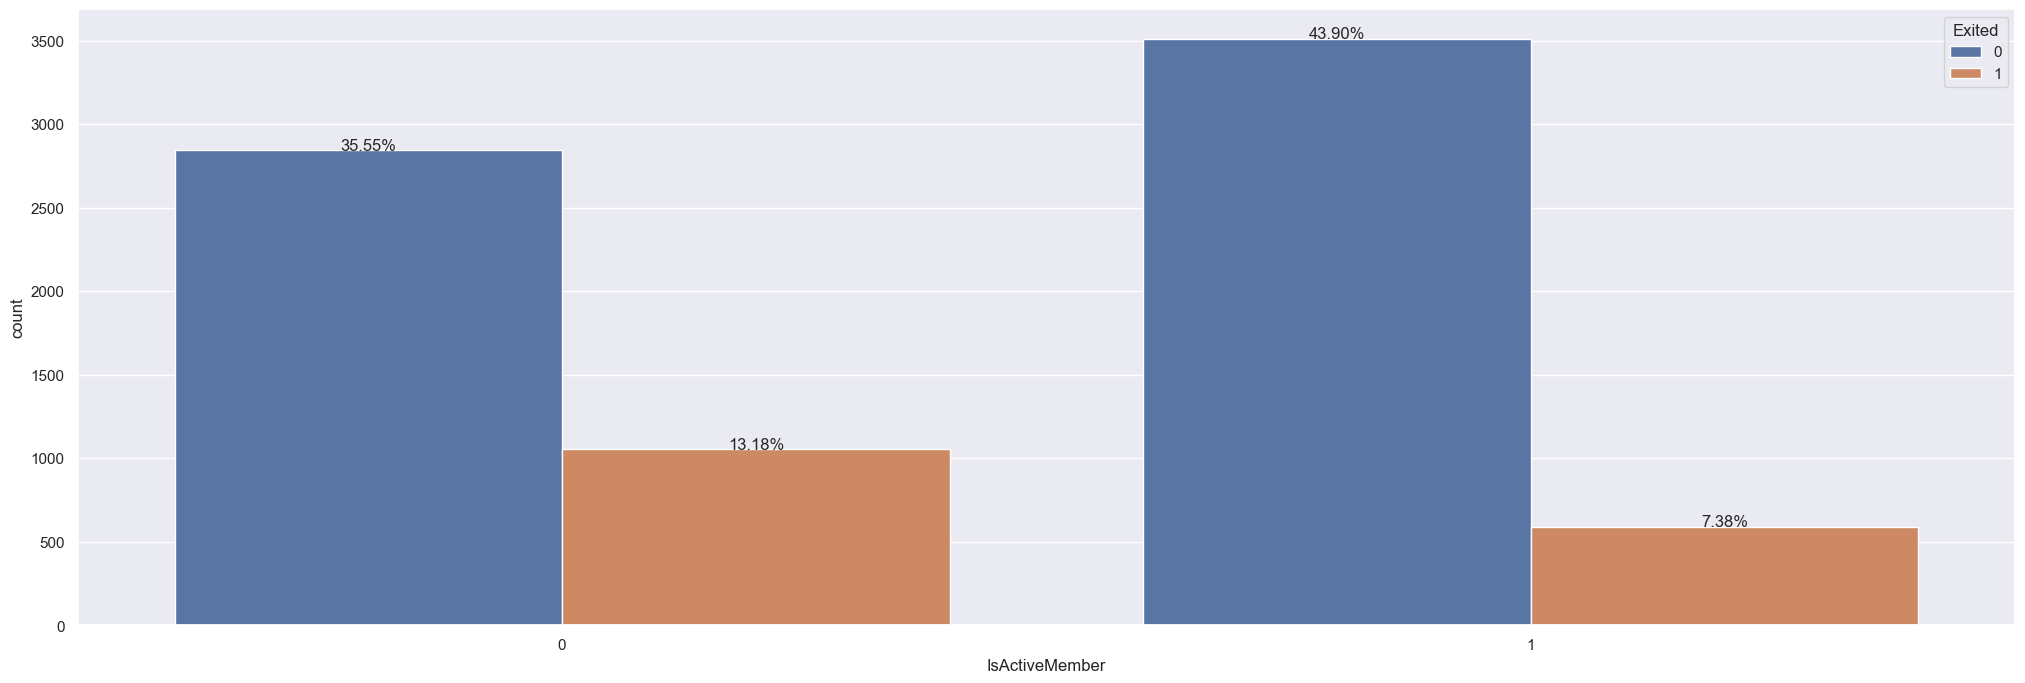

In [36]:
ax1 = sns.countplot(x = 'IsActiveMember', hue = 'Exited', data = df4)
show_percentage(ax1, df4)

#### 4.1.10 EstimatedSalary

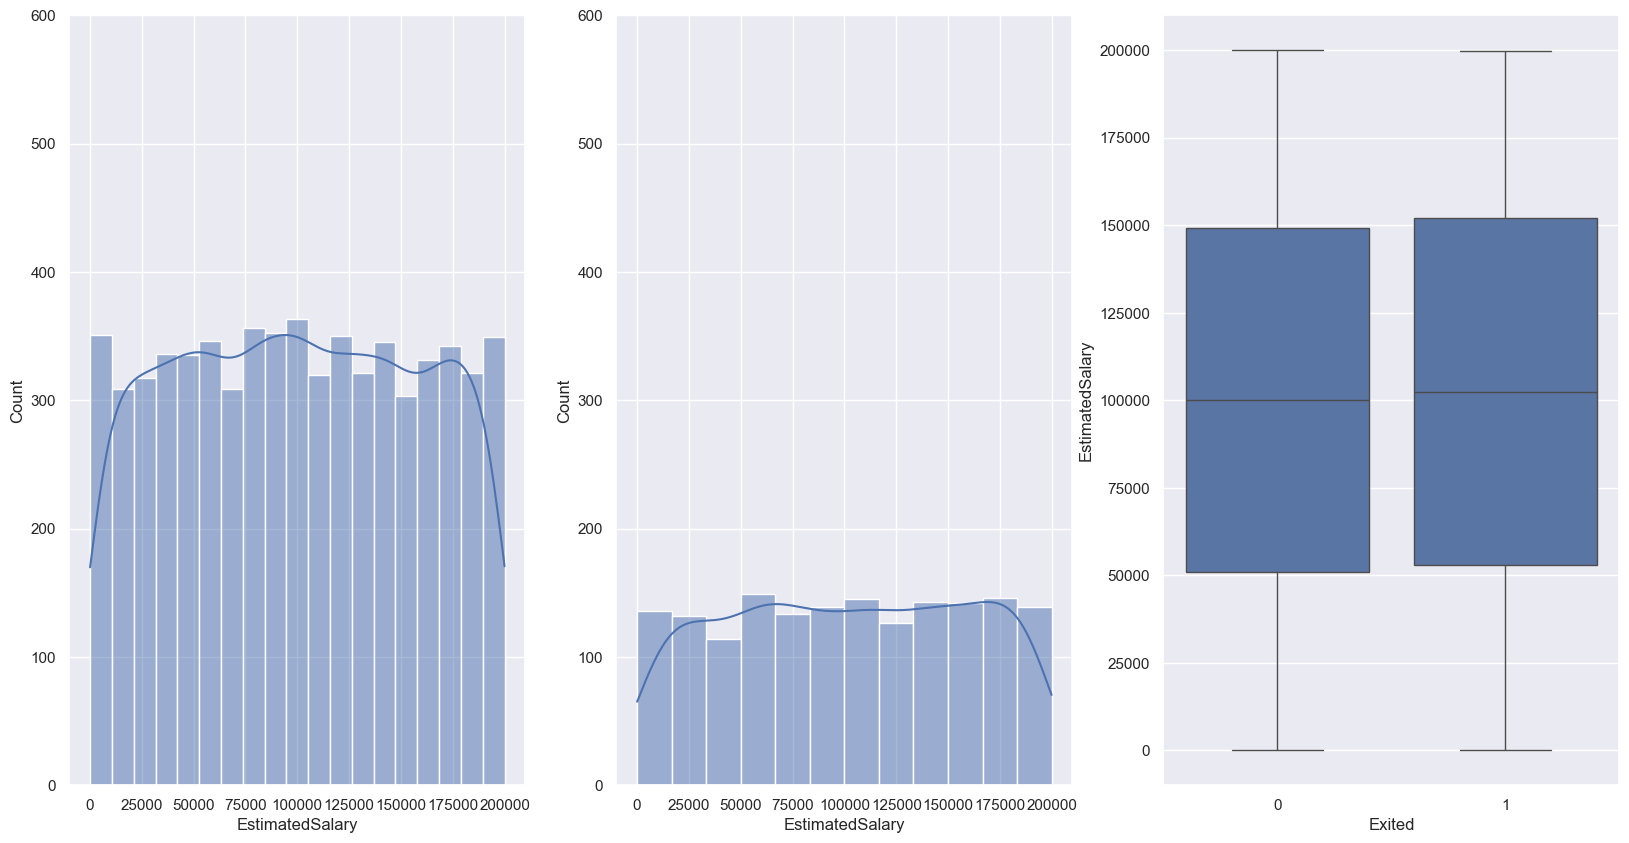

In [37]:
# Age
plt.figure(figsize = (20, 10))
aux_0 = df4.loc[df4['Exited'] == 0, 'EstimatedSalary']
aux_1 = df4.loc[df4['Exited'] == 1, 'EstimatedSalary']

max_y = max(aux_0.max(), aux_1.max())

plt.subplot(1, 3, 1)
sns.histplot(aux_0, kde = True)
plt.ylim(0, 600)

plt.subplot(1, 3, 2)
sns.histplot(aux_1, kde = True)
plt.ylim(0, 600)

plt.subplot(1, 3, 3)
sns.boxplot(x = df4['Exited'], y = df4['EstimatedSalary']);

#### 4.1.11 Credit Status

### 4.1.2 Análise Bivariada

### 4.1.3 Análise Multivariada

## 5.0. DATA PREPARATION

In [38]:
df5 = df4.copy()

In [39]:
x_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,686,France,0,32,6,0.00,2,1,1,179093.26
1561,632,Germany,0,42,4,119624.60,2,1,1,195978.86
1670,559,Spain,0,24,3,114739.92,1,1,0,85891.02
6087,561,France,1,27,9,135637.00,1,1,0,153080.40
6669,517,France,0,56,9,142147.32,1,0,0,39488.04


### 5.1 Training Dataset

#### 5.1.1 Normalização

In [40]:
# Standard Scaler

ssc_creditscore = pp.StandardScaler()
ssc_age = pp.StandardScaler()
ssc_balance = pp.StandardScaler()
ssc_estimatedsalary = pp.StandardScaler()

x_train['CreditScore'] = ssc_creditscore.fit_transform(x_train[['CreditScore']].values)
x_train['Age'] = ssc_age.fit_transform(x_train[['Age']].values)
x_train['Balance'] = ssc_balance.fit_transform(x_train[['Balance']].values)
x_train['EstimatedSalary'] = ssc_estimatedsalary.fit_transform(x_train[['EstimatedSalary']].values)

#### 5.1.2 Encoders

In [41]:
# Target Encoder
target_encoding_geography = df5.groupby('Geography')['Exited'].mean()
x_train.loc[:, 'Geography'] = x_train['Geography'].map(target_encoding_geography)

In [42]:
oe_numofproducts = pp.OrdinalEncoder()
x_train['NumOfProducts'] = oe_numofproducts.fit_transform(x_train[['NumOfProducts']].values)

### 5.2 Test Dataset

#### 5.1.1 Normalização

In [43]:
x_test['CreditScore'] = ssc_creditscore.transform(x_test[['CreditScore']].values)
x_test['Age'] = ssc_age.transform(x_test[['Age']].values)
x_test['Balance'] = ssc_balance.transform(x_test[['Balance']].values)
x_test['EstimatedSalary'] = ssc_estimatedsalary.transform(x_test[['EstimatedSalary']].values)

#### 5.1.2 Encoders

In [44]:
# Target Encoder
x_test.loc[:, 'Geography'] = x_test['Geography'].map(target_encoding_geography)

In [45]:
x_test['NumOfProducts'] = oe_numofproducts.fit_transform(x_test[['NumOfProducts']].values)

## 6.0. FEATURE SELECTION

In [46]:
x_train_n = x_train.loc[:, ~x_train.columns.isin(['RowNumber', 'CustomerId', 'Exited'])]
y_train_n = y_train.values

### 6.1 Feature Importance

In [47]:
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs = -1)
feature_names = [f"feature {i}" for i in range(x_train_n.shape[1])]

forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
           feature  importance
0              Age    0.232208
0    NumOfProducts    0.146622
0      CreditScore    0.130614
0  EstimatedSalary    0.130609
0          Balance    0.130220
0           Tenure    0.105210
0        Geography    0.047306
0   IsActiveMember    0.035765
0        HasCrCard    0.023120
0           Gender    0.018326


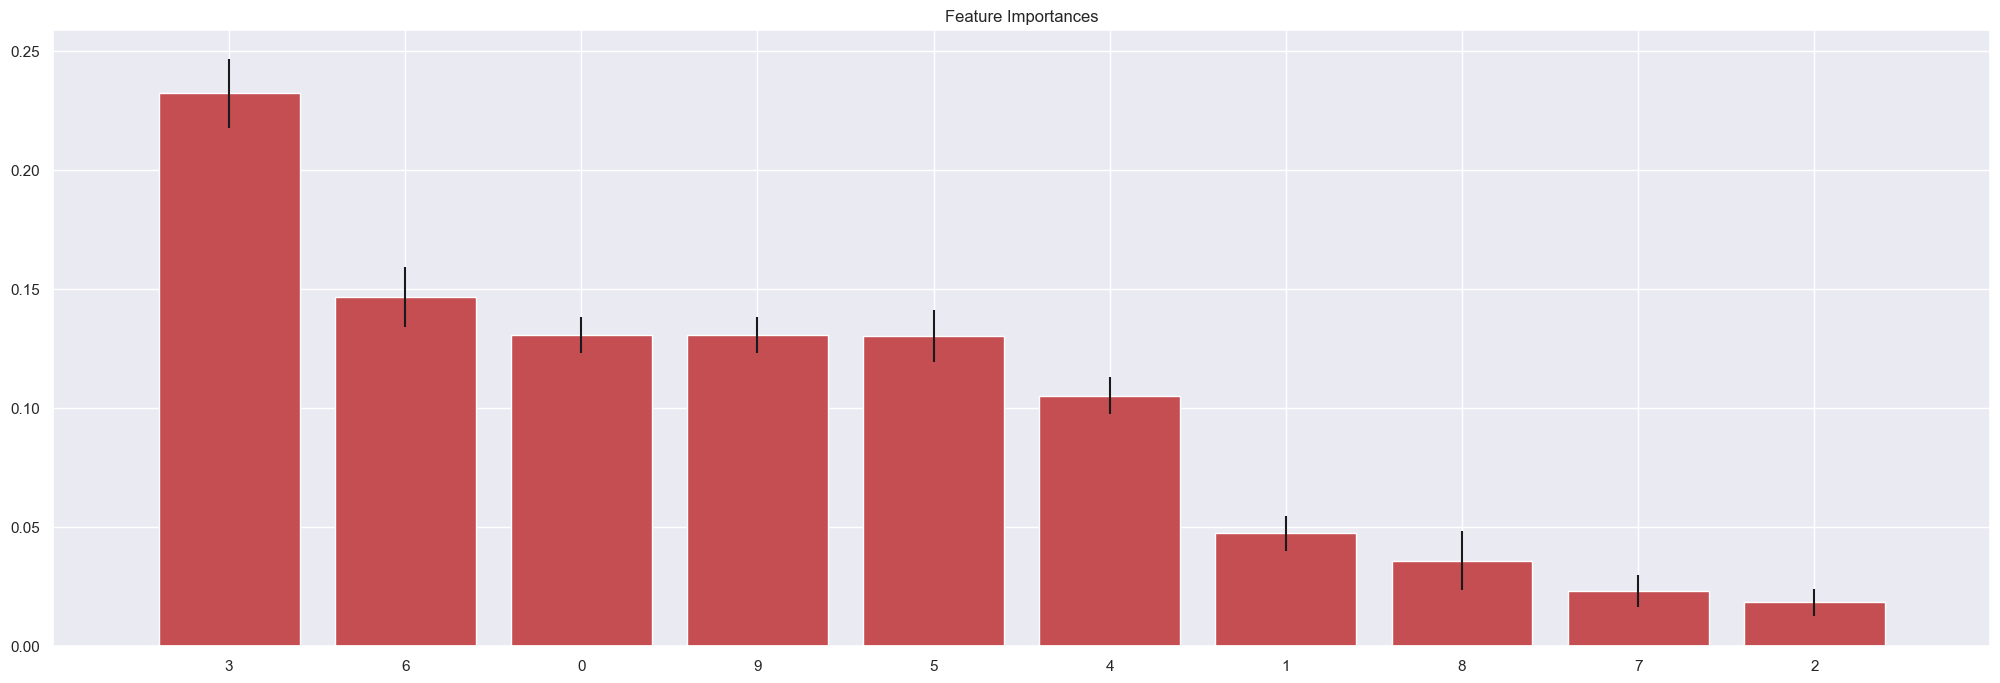

In [48]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, importances):
    aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis = 0)

print(df.sort_values('importance' ,ascending= False))
    
# Plot
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align = "center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

### 6.2 Boruta

In [49]:
from boruta import BorutaPy

model = en.RandomForestClassifier(n_estimators = 500, random_state=0, n_jobs = -1)
boruta = BorutaPy(model, n_estimators='auto', random_state=0, verbose=2).fit(x_train_n.values, y_train_n)

cols_selected = boruta.support_.tolist()
# best features
X_train_fs = x_train.copy()
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
# not_selected_boruta 
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

cols_selected_boruta

###['CreditScore', 'Age', 'Balance', 'NumOfProducts']
## ['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration:

['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### 6.3 Best Features

In [50]:
cols_selected = ['Age',
                 'NumOfProducts',
                 'Balance',
                 'CreditScore',
                 'EstimatedSalary',
                 'Tenure',
                 'IsActiveMember']

x_train = x_train[cols_selected]
x_test = x_test[cols_selected]

## 7.0. MACHINE LEARNING MODELING

### 7.1 Extra Trees Classifier

In [64]:
model = en.ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)
y_prob_test = (y_prob[:, 1] >= 0.7).astype(int)

result = precision_recall_at_k('Random Forest', x_test, y_test, y_prob, top_k = 1000)
display(result)

,Model Name,Precision at k,Recall at k
0,Random Forest,0.3407,0.8677


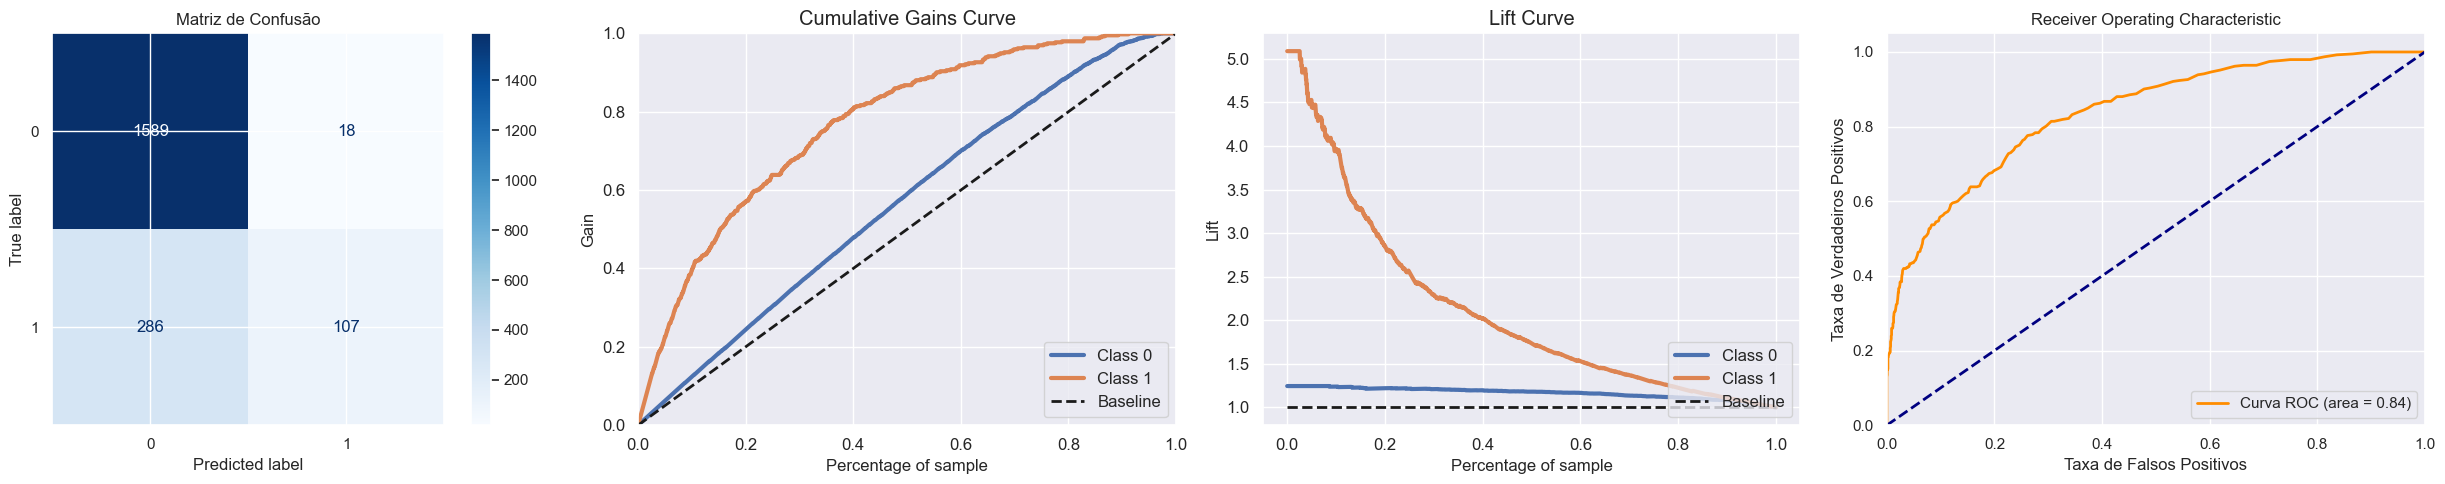

In [65]:
# Nomes das classes
class_names = [str(i) for i in range(len(set(y_test)))]

# Criando a matriz de confusão
cm = confusion_matrix(y_test, y_prob_test)

# Criando a figura com 5 subplots (1 a mais para a análise da matriz de confusão)
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

# Selecionando o primeiro subplot e plotando a matriz de confusão
ax1 = ax[0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax1, cmap='Blues')
ax1.set_title('Matriz de Confusão')


# Cumulative Gains
skplt.metrics.plot_cumulative_gain(y_test, y_prob, ax=ax[1])


# Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_prob, ax=ax[2])


# ROC AUC

roc_score = roc_auc_score(y_test, y_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])


# Plotar a curva ROC

ax[3].plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_score)
ax[3].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[3].set_xlim([0.0, 1.0])
ax[3].set_ylim([0.0, 1.05])
ax[3].set_xlabel('Taxa de Falsos Positivos')
ax[3].set_ylabel('Taxa de Verdadeiros Positivos')
ax[3].set_title('Receiver Operating Characteristic')
ax[3].legend(loc="lower right")

# Mostrar os gráficos
plt.tight_layout()
plt.show()

### 7.1.1 Cross Validation

In [66]:

et_cv = cross_validation('K-NN', model, x_train, x_test, y_train, y_test, 5, 2, top_k=1000)
et_cv

,Model Name,Precision,Recall
0,K-NN,0.345+/-0.01,0.848+/-0.01


## 8.0. HIPERPARAMETER FINE-TUNNING

## 9.0. FINAL MODEL

## 10.0. DEPLOY